# Mecánica Celeste: teoría, algoritmos y problemas
# Por Jorge I. Zuluaga

En estos cuadernos hemos compilado la mayoría de los códigos que vienen con el libro [**Mecánica Celeste: teoría, algoritmos y problemas**](https://www.buscalibre.com.co/libro-mecanica-celeste-teoria-algoritmos-y-problemas/9789585011953/p/62242977?afiliado=74c874bfb5a8145d7c1b). En cada cuaderno encontrará códigos de secciones o capítulos enteros. Para explicaciones detalladas de lo que hacen los códigos refiérase a la sección o capítulo respectivo. Para mayor comodidad puede leer o ejecutar este cuaderno usando `Google Colab`.

<a target="_blank" href="https://colab.research.google.com/github/seap-udea/pymcel/blob/main/ejemplos/cuadernos-libro/mcel_zuluaga-dinamica_sistemas_rotantes.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Algorítmos Sistemas de Referencia Rotantes

### Instalación e importación

Si está usando este cuaderno en `Colab` debería instalar `pymcel` antes de comenzar: 

In [16]:
!pip install -Uq pymcel

In [1]:
# Este código se usa solamente para desarrollar estos cuadernos pero es inocuo en otros contextos
%load_ext autoreload 
%autoreload 2

### Un ejemplo numérico

Un campo de aceleraciones:

In [4]:
# Ecuación de la aceleración inercial
def a_inercial(t,r,v,parametros):
    from numpy.linalg import norm
    k=parametros["k"]
    n=parametros["n"]
    a=-k*r/norm(r)**(n+1)
    return a

# Ecuación de movimiento de un cuerpo sometido a una aceleración general
def edm_sistema_general(Y,t,aceleracion,parametros):
    from numpy import zeros
    dYdt=zeros(6)
    
    dYdt[:3]=Y[3:]
    dYdt[3:]=aceleracion(t,Y[:3],Y[3:],parametros)

    return dYdt

Solución numérica a las ecuaciones de movimiento:

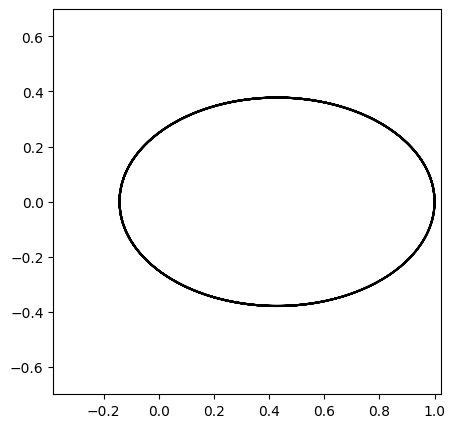

In [7]:
#Condiciones iniciales
from numpy import array,concatenate
ro_ine=array([1.0,0.0,0.0])
vo_ine=array([0.0,0.5,0.0])
Yos=concatenate((ro_ine,vo_ine))

#Parametros
parametros=dict(k=1,n=2,omega0=0.5)

#Tiempos para la integración
from numpy import linspace
Nt=1000
ts=linspace(0,10,Nt)

#Solución numérica
from scipy.integrate import odeint
Ys=odeint(edm_sistema_general,Yos,ts,args=(a_inercial,parametros))

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5));
ax=fig.gca()

ax.plot(Ys[:,0],Ys[:,1],'k-');

from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(ax,Ys[:,:2],ycm=0);

Movimiento visto desde el sistema de referencia rotante:

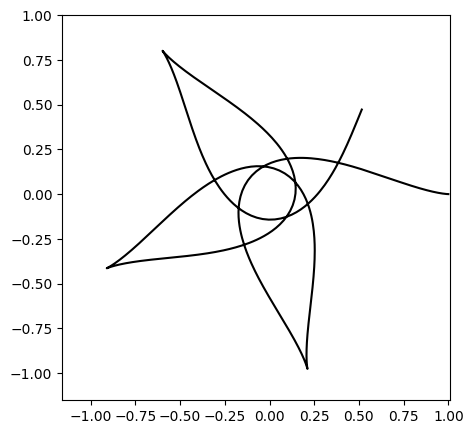

In [8]:
#Velocidad angular
from numpy import array
omega0=parametros["omega0"]
omega_vec=array([0,0,omega0])

#Extraemos las posiciones del vector solución
rs_ine=Ys[:,:3]
vs_ine=Ys[:,3:]

#Aquí almacenaremos las posiciones en el sistema rotante
from numpy import zeros_like
rs_rot=zeros_like(rs_ine)

#Aquí realizamos las rotaciones
for i in range(Nt):
    
    #Matriz de rotación
    from spiceypy import rotate
    R=rotate(omega0*ts[i],3)
    
    #Rotación del vector posición y el vector velocidad
    from spiceypy import mxv
    rs_rot[i]=mxv(R,rs_ine[i])

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5));
ax=fig.gca()
ax.plot(rs_rot[:,0],rs_rot[:,1],'k-');
from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(ax,rs_rot);

Cálculo de la velocidad desde el sistema rotante:

In [11]:
# Usando una expresión numérica
vs_rot_num=zeros_like(rs_rot)
for i in range(1,Nt):
    vs_rot_num[i]=(rs_rot[i]-rs_rot[i-1])/(ts[i]-ts[i-1])

print(f"Velocidad en el sistema rotante (numérica):\n{vs_rot_num[10:100:10,:2]}")

# Usando la expresión teórica
vs_rot_teo=zeros_like(rs_rot)
for i in range(1,Nt):
    from spiceypy import mxv,vcrss
    R=rotate(omega0*ts[i],3)
    vs_rot_teo[i]=mxv(R,vs_ine[i]-vcrss(omega_vec,rs_ine[i]))

print(f"Velocidad en el sistema rotante (teórica):\n{vs_rot_teo[10:100:10,:2]}")

Velocidad en el sistema rotante (numérica):
[[-0.07145671  0.00339554]
 [-0.14758785  0.01431325]
 [-0.22572748  0.03281623]
 [-0.30723691  0.05897703]
 [-0.39396346  0.09286195]
 [-0.4885779   0.13446222]
 [-0.59515829  0.18352756]
 [-0.72028609  0.23914758]
 [-0.87529827  0.29861119]]
Velocidad en el sistema rotante (teórica):
[[-0.07523279  0.00375907]
 [-0.1514363   0.01505464]
 [-0.22970852  0.03393858]
 [-0.31142896  0.06048423]
 [-0.39847652  0.0947563 ]
 [-0.49357555  0.13673899]
 [-0.6008967   0.18616246]
 [-0.72719054  0.24206358]
 [-0.88412796  0.30158388]]


Calculemos ahora la aceleración numérica y teórica:

In [12]:
as_rot_num=zeros_like(rs_rot)
as_rot_teo=zeros_like(rs_rot)

for i in range(1,Nt):
    from spiceypy import mxv,vcrss
    R=rotate(omega0*ts[i],3)
    
    #Aceleración numérica
    as_rot_num[i]=(vs_rot_num[i]-vs_rot_num[i-1])/(ts[i]-ts[i-1])
    
    #Aceleración inercial (en el sistema inercial de referencia)
    a_ine=a_inercial(ts[i],rs_ine[i],vs_ine[i],parametros)
    
    #Aceleración centrífuga (en el sistema inercial de referencia)
    acen_ine=-vcrss(omega_vec,vcrss(omega_vec,rs_ine[i]))
    
    #Aceleración de Coriolis (en el sistema inercial de referencia)
    acor_ine=-2*vcrss(omega_vec,vs_ine[i])
    
    #Aceleración en el sistema rotante
    as_rot_teo[i]=mxv(R,a_ine+acen_ine+acor_ine)

print(f"Aceleracion en el sistema rotante (numérica):\n{as_rot_num[10:100:10,:2]}")
print(f"Aceleracion en el sistema rotante (teórica):\n{as_rot_teo[10:100:10,:2]}")

Aceleracion en el sistema rotante (numérica):
[[-0.75384218  0.06761248]
 [-0.76762841  0.14306084]
 [-0.79322576  0.21914026]
 [-0.83417784  0.29599092]
 [-0.89660424  0.37331668]
 [-0.99079222  0.44986923]
 [-1.13456262  0.52197651]
 [-1.36034815  0.57974027]
 [-1.73172371  0.59572959]]
Aceleracion en el sistema rotante (teórica):
[[-0.25662755  0.07520001]
 [-0.2771494   0.15113843]
 [-0.31361247  0.22848776]
 [-0.369907    0.30773656]
 [-0.45267897  0.38892602]
 [-0.57312374  0.471024  ]
 [-0.75060302  0.55035606]
 [-1.02041835  0.61636549]
 [-1.45210627  0.63882753]]


Aceleración experimentada en el sistema de referencia rotante:

In [13]:
def a_rotante(t,r,v,parametros):
    
    omega0=parametros["omega0"]
    
    from spiceypy import rotate,mxv,vcrss,invert
    R=rotate(omega0*t,3) 
    
    #Primero convierte r,v al sistema inercial
    r_ine=mxv(invert(R),r)
    v_ine=mxv(invert(R),v)
    
    #Calcula la aceleración en el sistema inercial
    ainercial=a_inercial(t,r_ine,v_ine,parametros)

    #Rota la aceleración inercial a los ejes rotantes
    ainercial_rot=mxv(R,ainercial)
    
    #Calcular la aceleración en el sistema rotante
    acen_rot=-vcrss(omega_vec,vcrss(omega_vec,r))
    acor_rot=-2*vcrss(omega_vec,v)
    a_rot=ainercial_rot+acen_rot+acor_rot
    return a_rot

Solución a la ecuación diferencial:

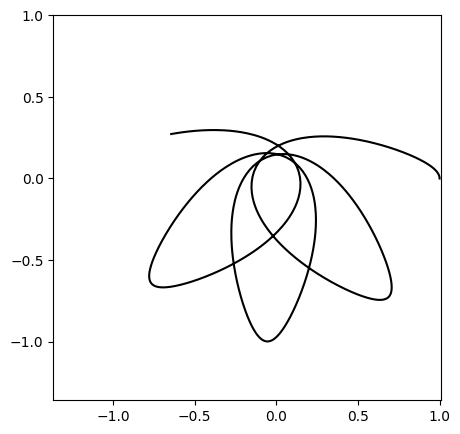

In [14]:
#Convertimos las condiciones iniciales, al sistema rotante
from spiceypy import rotate,mxv

parametros=dict(k=1,n=2,omega0=0.3)
ro_ine=array([1.0,0.0,0.0])
vo_ine=array([0.0,0.5,0.0])
omega0=parametros["omega0"]
omega_vec=array([0,0,omega0])

ro_rot=ro_ine
R=rotate(0.0,3)
vo_rot=mxv(R,vo_ine-vcrss(omega_vec,ro_ine))

#Condiciones iniciales
from numpy import concatenate
Yos_rot=concatenate((ro_rot,vo_rot))

#Tiempos para la integración
from numpy import linspace
Nt=1000
ts=linspace(0,10,Nt)

#Solución numérica
from scipy.integrate import odeint
Ys_rot=odeint(edm_sistema_general,Yos_rot,ts,args=(a_rotante,parametros))

#Gráfico
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,5));
ax=fig.gca()
ax.plot(Ys_rot[:,0],Ys_rot[:,1],'k-');
from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(ax,Ys_rot[:,:2]);

Animemos el movimiento:

In [23]:
#Tiempos
Nt=300
T=30
ts=linspace(0,T,Nt)

#Parametros
parametros=dict(k=1,n=2,omega0=1.0)

#Sistema de referencia inercial
ro_ine=array([1.0,0.0,0.0])
vo_ine=array([0.0,0.8,0.0])
Yos=concatenate((ro_ine,vo_ine))
Ys=odeint(edm_sistema_general,Yos,ts,args=(a_inercial,parametros))

#Sistema de referencia rotante
ro_rot=ro_ine
R=rotate(0.0,3)
from numpy import array,cos,sin
omega_vec=array([0,0,parametros["omega0"]])
vo_rot=mxv(R,vo_ine-vcrss(omega_vec,ro_ine))
Yos_rot=concatenate((ro_rot,vo_rot))
Ys_rot=odeint(edm_sistema_general,Yos_rot,ts,args=(a_rotante,parametros))

#Gráfico básico
fig,axs=plt.subplots(1,2,figsize=(8,4))

inercial_punto,=axs[0].plot([],[],'ko');
inercial_linea,=axs[0].plot([],[],'b--');
inercial_xeje,=axs[0].plot([0,1],[0,0],'r:');
inercial_yeje,=axs[0].plot([0,0],[0,1],'r:');

axs[1].plot([0,1],[0,0],'r:');
axs[1].plot([0,0],[0,1],'r:');

axs[0].set_xlim((-1,1));
axs[0].set_ylim((-1,1));
axs[0].set_title("Sistema inercial")
axs[0].grid()

rotante_punto,=axs[1].plot([],[],'ko');
rotante_linea,=axs[1].plot([],[],'b--');
axs[1].set_xlim((-1,1));
axs[1].set_ylim((-1,1));
axs[1].set_title("Sistema rotante")
axs[1].grid()

from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(axs[0],Ys[:,:2],ycm=0);
fija_ejes_proporcionales(axs[1],Ys_rot[:,:2]);

def animacion(it):
    #Punto
    inercial_punto.set_data([Ys[it,0]],[Ys[it,1]])
    rotante_punto.set_data([Ys_rot[it,0]],[Ys_rot[it,1]])
    #Linea
    inercial_linea.set_data([Ys[:it,0]],[Ys[:it,1]])
    rotante_linea.set_data([Ys_rot[:it,0]],[Ys_rot[:it,1]])
    #Eje de sistema de referencia
    x_eje=cos(parametros["omega0"]*it*T/Nt)
    y_eje=sin(parametros["omega0"]*it*T/Nt)
    inercial_xeje.set_data([0,x_eje],[0,y_eje])
    inercial_yeje.set_data([0,-y_eje],[0,x_eje])
    
    return inercial_punto,inercial_linea,rotante_punto,rotante_linea
 
from matplotlib import animation
anim=animation.FuncAnimation(fig,animacion,frames=Nt,interval=100,blit=True,repeat=False);
plt.close('all')

from IPython.display import HTML
HTML(anim.to_html5_video())

<hr/>

Para explorar más cuadernos del libro vaya al [repositorio de en GitHub](https://github.com/seap-udea/pymcel/tree/main/ejemplos/cuadernos-libro)